This notebooks shows the cideMOD implementation of the SEI evolution in the negative electrode and compares it to the original reference [1] in which the implementation is based. The examples include the comparison of scenarios with different limiting processes (kinetic and diffusion) as well as cycling and OCV storage conditions.

[1] M. Safari et al 2009 J. Electrochem. Soc. 156 A145 doi: 10.1149/1.3043429

In [1]:
from cideMOD import (
    CellParser,
    ErrorCheck,
    NDProblem,
    Problem,
    SolverCrashed,
    Trigger,
    init_results_folder,
    ModelOptions,
    CSI
)
import json 

### Simulation settings
The SEI model is activated by setting the option `solve_SEI` to `True` in `ModelOptions`

In [ ]:
overwrite = False
case = "Safari_2009"
data_path = "../../data/data_{}".format(case)

model_options = ModelOptions(mode='P2D', clean_on_exit=False, solve_SEI=True)



## Cycling

In [3]:
V_app = 3.9
I_app = 0

days = 484
hours = days * 24
minutes = hours * 60
seconds = minutes * 60
t_f = seconds

In [4]:
n_cycles = 50

cycling = {
            "name": "Discharge Cycle",
            "type": "Cycle",
            "count": n_cycles,
            "steps": [
                {
                    "name": "Discharge",
                    "type": "Current", 
                    "value": "-0.5*1.8", 
                    "unit": "A", 
                    "t_max": {"value": 2.5, "unit": "h"},
                    "store_delay": -1 ,
                    "min_step": 30,
                    "events": [
                        {
                            "type": "Voltage",
                            "value": 2,  
                            "unit": "V",  
                            "atol": 1e-4, 
                            "rtol": 1e-3,
                            "goto": "Next" 
                        }
                    ]
                },
                {
                    "name": "Charge",
                    "type": "Current", 
                    "value": "0.5*1.8", 
                    "unit": "A", 
                    "t_max": {"value": 2.5, "unit": "h"},
                    "store_delay": -1 ,
                    "min_step": 30,
                    "events": [
                        {
                            "type": "Voltage",
                            "value": 4.2,  
                            "unit": "V",  
                            "atol": 1e-4, 
                            "rtol": 1e-3,
                            "goto": "CV" 
                        }
                    ]
                }
            ]}

cycling_test_plan = {
    'initial_state': {
        'SOC': 1,
        'exterior_temperature': 298
    },
    'steps': [cycling]
}

### Reaction limited case

In [ ]:
cell = json.load(open(data_path+"/params_cycling_lumped.json"))
cell["negativeElectrode"]["SEI"]["solventDiffusion"].update({"value": 1.3e-15})
cell["negativeElectrode"]["SEI"]["rateConstant"].update({"value": 1.36e-12})

bms_rl = CSI(cell, model_options, data_path, name=f'{case}_rl', overwrite=overwrite)
bms_rl.read_test_plan(cycling_test_plan)
bms_rl.run_test_plan()

problem_rl = bms_rl.problem

### Diffusion limited case

In [ ]:
cell["negativeElectrode"]["SEI"]["solventDiffusion"].update({"value": 6.8e-21})
cell["negativeElectrode"]["SEI"]["rateConstant"].update({"value": 1.36e-7})
bms_dl = CSI(cell, model_options, data_path, name=f'{case}_dl', overwrite=overwrite)
bms_dl.read_test_plan(cycling_test_plan)
bms_dl.run_test_plan()

problem_dl = bms_dl.problem

# Compare results

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import numpy
from scipy.interpolate import interp1d
# matplotlib.use('Agg')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

safari_rl = numpy.genfromtxt("../../data/data_Safari_2009/SEI_resistance_rl.txt", delimiter=' ')
safari_dl = numpy.genfromtxt("../../data/data_Safari_2009/SEI_resistance_dl.txt", delimiter=' ')

### SEI resistance

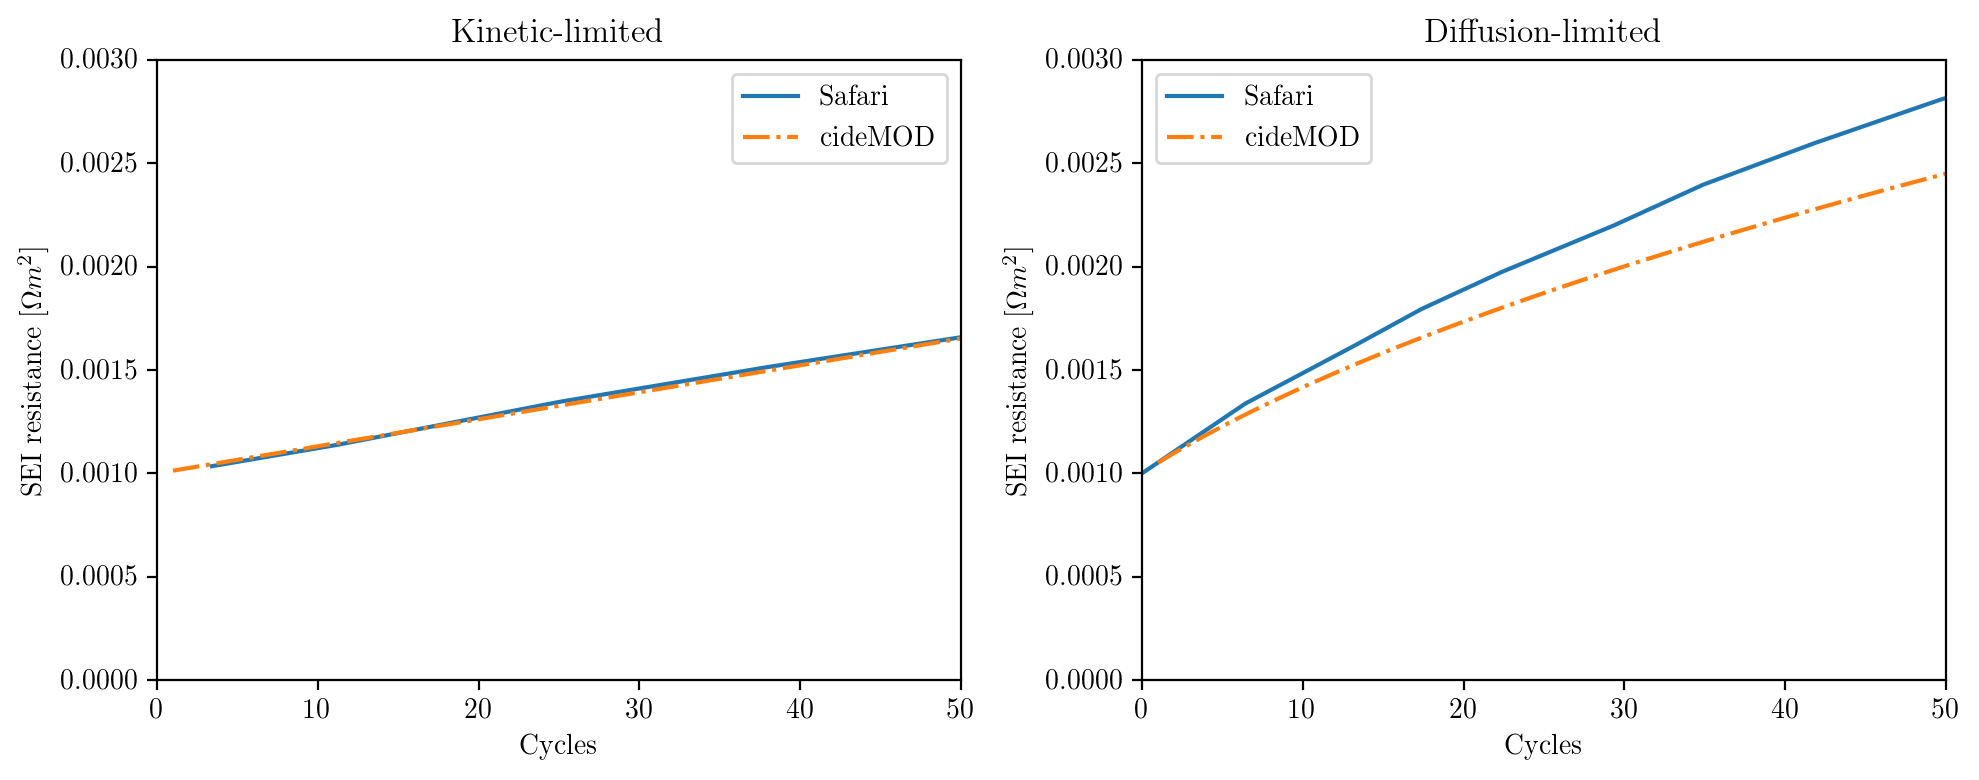

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=200)

# Reaction limited
time = problem_rl.WH.get_global_variable('time')
cur = problem_rl.WH.get_global_variable('current')
index = numpy.append(numpy.where(numpy.diff(cur)<(-0.5*1.8))[0], len(cur)-1)
nCycles = len(index)
cycles_rl = numpy.arange(1,nCycles+1)
thickness = problem_rl.WH.get_global_variable('delta_sei_a0')
av_thickness_rl = numpy.array(thickness)[index]


ax1.plot(safari_rl[:,0], safari_rl[:,1], "-")
ax1.plot(cycles_rl, av_thickness_rl/problem_rl.anode.SEI.kappa, "-.")
ax1.set_xlabel("Cycles")
ax1.set_ylabel("SEI resistance [$\Omega m^2$]")
ax1.legend(["Safari", "cideMOD"], loc="best")
ax1.set_ylim([0, 0.003])
ax1.set_xlim([0, nCycles])
ax1.title.set_text("Kinetic-limited")

time = problem_dl.WH.get_global_variable('time')
cur = problem_dl.WH.get_global_variable('current')
index = numpy.append(numpy.where(numpy.diff(cur)<(-0.5*1.8))[0], len(cur)-1)
nCycles = len(index)
cycles_dl = numpy.arange(1,nCycles+1)
thickness = problem_dl.WH.get_global_variable('delta_sei_a0')
av_thickness_dl = numpy.array(thickness)[index]
ax2.plot(safari_dl[:,0], safari_dl[:,1], "-")
ax2.plot(cycles_dl, av_thickness_dl/problem_dl.anode.SEI.kappa, "-.")
ax2.set_xlabel("Cycles")
ax2.set_ylabel("SEI resistance [$\Omega m^2$]")
ax2.legend(["Safari", "cideMOD"], loc="best")
ax2.set_ylim([0, 0.003])
ax2.set_xlim([0, nCycles])
ax2.title.set_text("Diffusion-limited")

plt.tight_layout()
plt.show()
# plt.savefig("Cycles.png")

### RMSE cycling

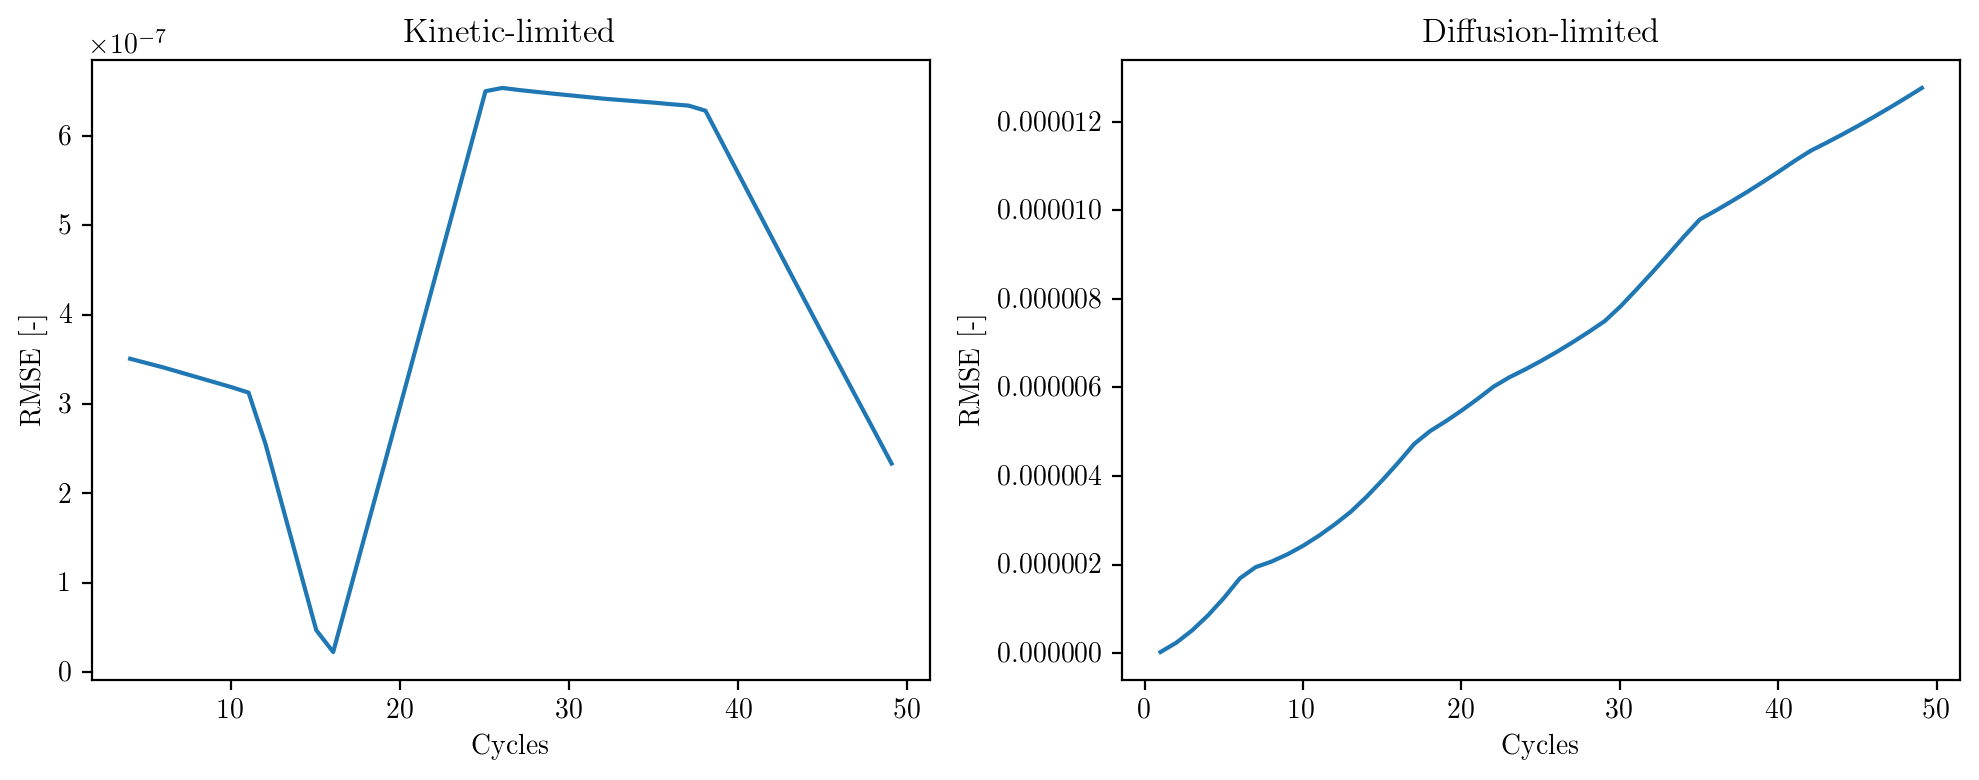

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=200)
time = numpy.linspace(0, 800, 800)

real_dl = interp1d(safari_dl[:,0], safari_dl[:,1], bounds_error=False)
cidemod_dl = interp1d(cycles_dl, av_thickness_dl.flatten()/problem_dl.anode.SEI.kappa, bounds_error=False)
real_rl = interp1d(safari_rl[:,0], safari_rl[:,1], bounds_error=False)
cidemod_rl = interp1d(cycles_rl, av_thickness_rl.flatten()/problem_rl.anode.SEI.kappa, bounds_error=False)

# plot the RMSE over cycles
ax1.plot(time, numpy.sqrt((real_rl(time)-cidemod_rl(time))**2/len(time)), "-")
ax1.set_xlabel("Cycles")
ax1.set_ylabel("RMSE [-]")
ax1.title.set_text("Kinetic-limited")

# plot the RMSE over cycles
ax2.plot(time, numpy.sqrt((real_dl(time)-cidemod_dl(time))**2/len(time)), "-")
ax2.set_xlabel("Cycles")
ax2.set_ylabel("RMSE [-]")
ax2.title.set_text("Diffusion-limited")

plt.tight_layout()
plt.show()
# plt.savefig("Cycles_RMSE.png")

### Voltage comparison

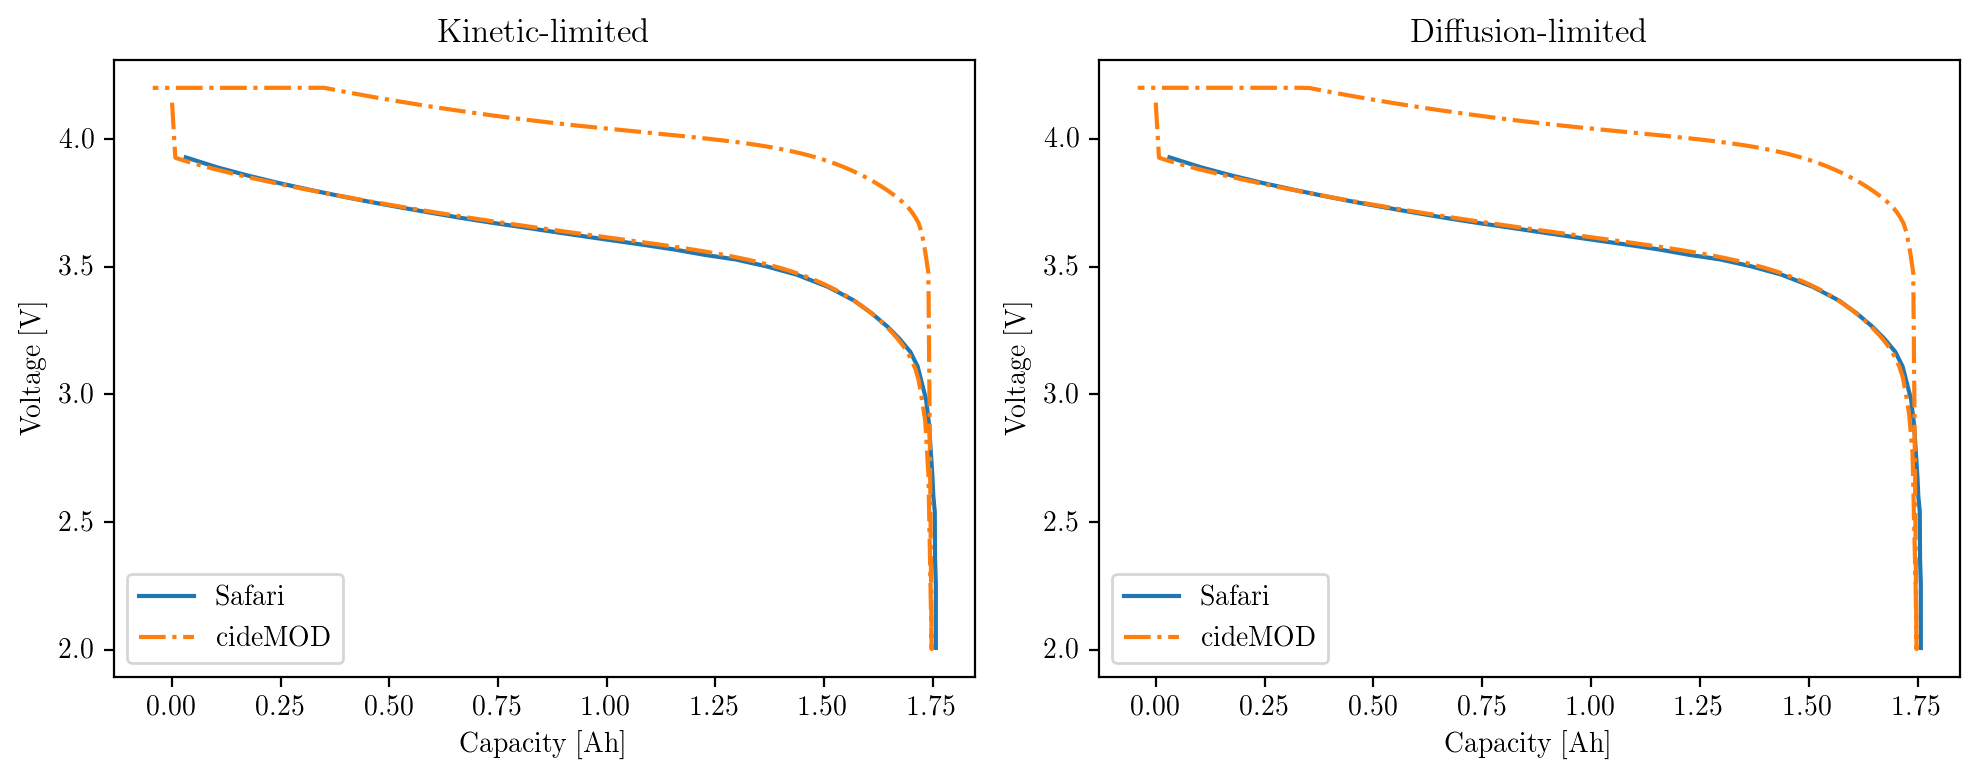

In [10]:
safari_rl = numpy.genfromtxt("../../data/data_Safari_2009/voltage_rl.txt", delimiter='\t')
safari_dl = numpy.genfromtxt("../../data/data_Safari_2009/voltage_dl.txt", delimiter='\t')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=200)
# Reaction limited case
cur = problem_rl.WH.get_global_variable('current')
capacity = problem_rl.WH.get_global_variable('capacity')
voltage = problem_rl.WH.get_global_variable('voltage')
index = numpy.append(numpy.where(numpy.diff(cur)<(-0.5*1.8))[0], len(cur)-1)

ax1.plot(safari_rl[:,0], safari_rl[:,1], "-")
ax1.plot(capacity[0:index[0]], voltage[0:index[0]], "-.")
ax1.set_xlabel("Capacity [Ah]")
ax1.set_ylabel("Voltage [V]")
ax1.legend(["Safari - dch", "cideMOD - dch/ch"], loc="best")
# ax1.set_ylim([0, 0.003])
# ax1.set_xlim([0, 800])
ax1.title.set_text("Kinetic-limited")

# Diffusion limited case
cur = problem_dl.WH.get_global_variable('current')
capacity = problem_dl.WH.get_global_variable('capacity')
voltage = problem_dl.WH.get_global_variable('voltage')
index = numpy.append(numpy.where(numpy.diff(cur)<(-0.5*1.8))[0], len(cur)-1)

ax2.plot(safari_dl[:,0], safari_dl[:,1], "-")
ax2.plot(capacity[0:index[0]], voltage[0:index[0]], "-.")
ax2.set_xlabel("Capacity [Ah]")
ax2.set_ylabel("Voltage [V]")
ax2.legend(["Safari - dch", "cideMOD - dch/ch"], loc="best")
ax2.title.set_text("Diffusion-limited")

plt.tight_layout()
plt.show()
# plt.savefig("Cycles_voltaje.png")

## Compare cycling parameters and OCV parameters

In [11]:
safari_Q_cycling = numpy.genfromtxt("../../data/data_Safari_2009/capacity_loss_cycling.txt", delimiter='\t')
safari_Q_OCV = numpy.genfromtxt("../../data/data_Safari_2009/capacity_loss_ocv.txt", delimiter='\t')

#### OCV

In [ ]:
cell_ocv = CellParser("params_OCV.json", data_path=data_path)

problem_ocv = Problem(cell_ocv, model_options)
problem_ocv.set_cell_state(0.99, 273 + 25, 273 + 25)
problem_ocv.setup()

v_min = Trigger(2.5, "v")
status = problem_ocv.solve_ie(
    min_step=5, max_step=30*24*3600, i_app=I_app, t_f=t_f, store_delay=-1, adaptive=True, triggers=[v_min]
)
err = ErrorCheck(problem_ocv, status)

if isinstance(status, SolverCrashed):
    raise status.args[0]

In [13]:
time_ocv = numpy.array(problem_ocv.WH.get_global_variable('time'))
capacity_loss_ocv = numpy.array(problem_ocv.WH.get_global_variable('Q_sei_a0'))

#### Cycling

In [ ]:
cell_cy = CellParser("params_cycling_lumped.json", data_path=data_path)

problem_cy = Problem(cell_cy, model_options)
problem_cy.set_cell_state(0.99, 273 + 25, 273 + 25)
problem_cy.setup()

v_min = Trigger(2.5, "v")
status = problem_cy.solve_ie(
    min_step=5, max_step=30*24*3600, i_app=I_app, t_f=t_f, store_delay=-1, adaptive=True, triggers=[v_min]
)
err = ErrorCheck(problem_cy, status)

if isinstance(status, SolverCrashed):
    raise status.args[0]


In [15]:
time_cy = numpy.array(problem_cy.WH.get_global_variable('time'))
capacity_loss_cy = numpy.array(problem_cy.WH.get_global_variable('Q_sei_a0'))

#### Plot

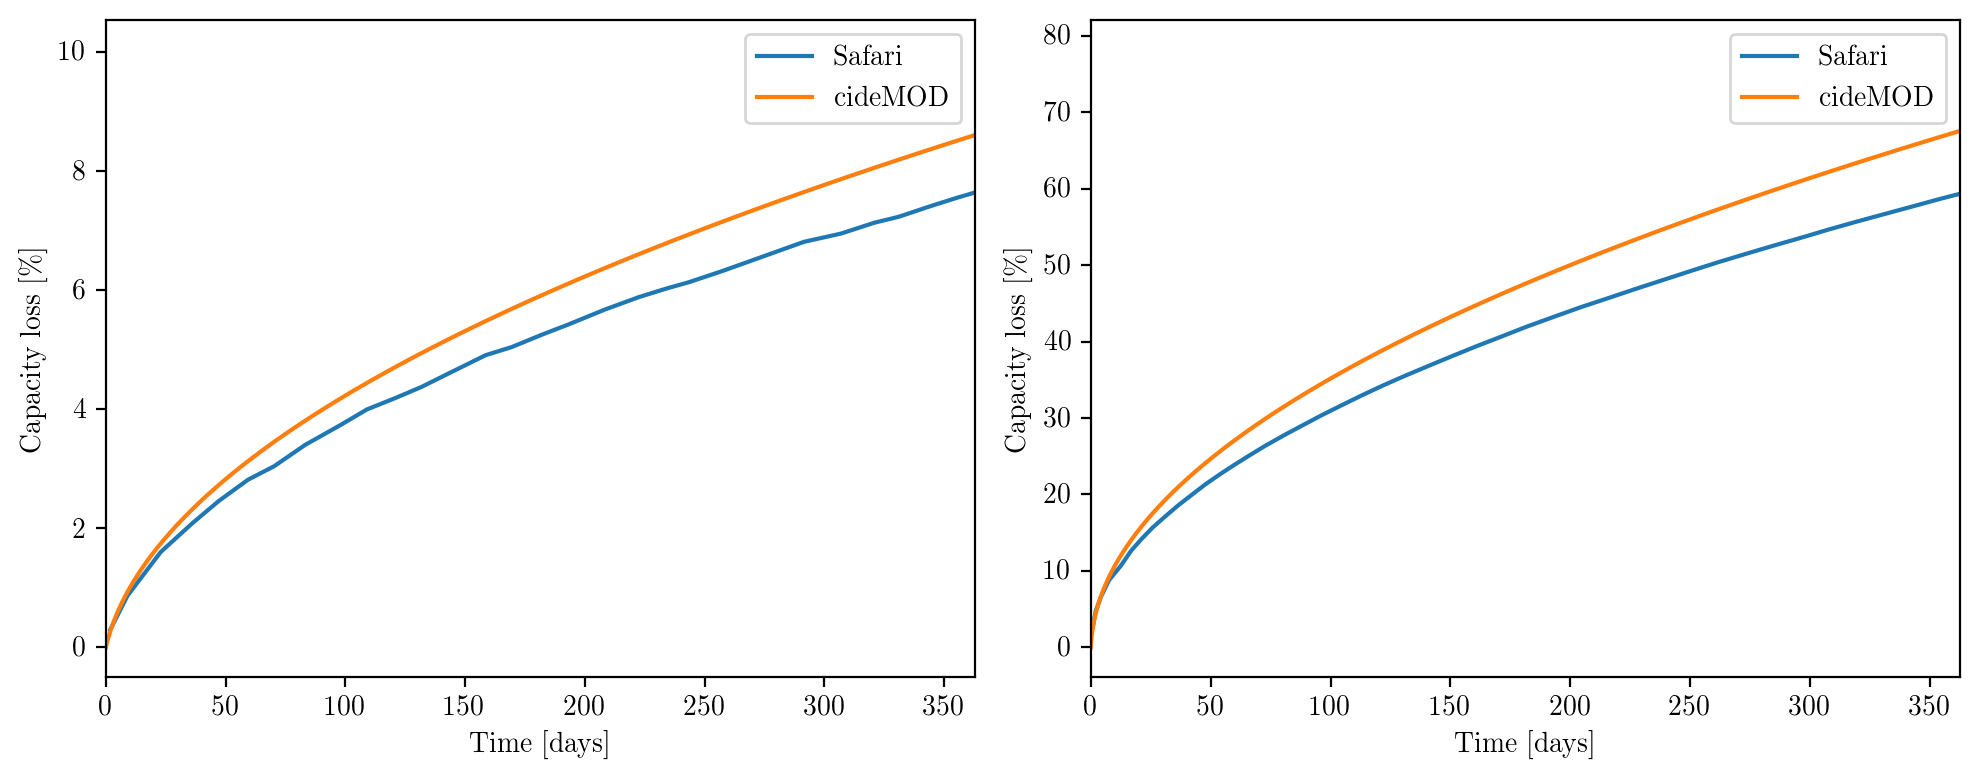

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=200)

# plot results over time
ax1.plot(safari_Q_cycling[:,0], safari_Q_cycling[:,1]*100, "-")
ax1.plot(time_cy/3600/24, capacity_loss_cy/1.8*100, "-")
ax1.set_xlabel("Time [days]")
ax1.set_ylabel(r"Capacity loss [\%]")
ax1.legend(["Safari", "cideMOD"], loc="best")
ax1.set_xlim([0, max(safari_Q_cycling[:,0])])

ax2.plot(safari_Q_OCV[:,0], safari_Q_OCV[:,1]*100, "-")
ax2.plot(time_ocv/3600/24, capacity_loss_ocv/1.8*100, "-")
ax2.set_xlabel("Time [days]")
ax2.set_ylabel(r"Capacity loss [\%]")
ax2.legend(["Safari", "cideMOD"], loc="best")
ax2.set_xlim([0, max(safari_Q_OCV[:,0])])

plt.tight_layout()
plt.show()
# plt.savefig("Storage.png")


### RSME

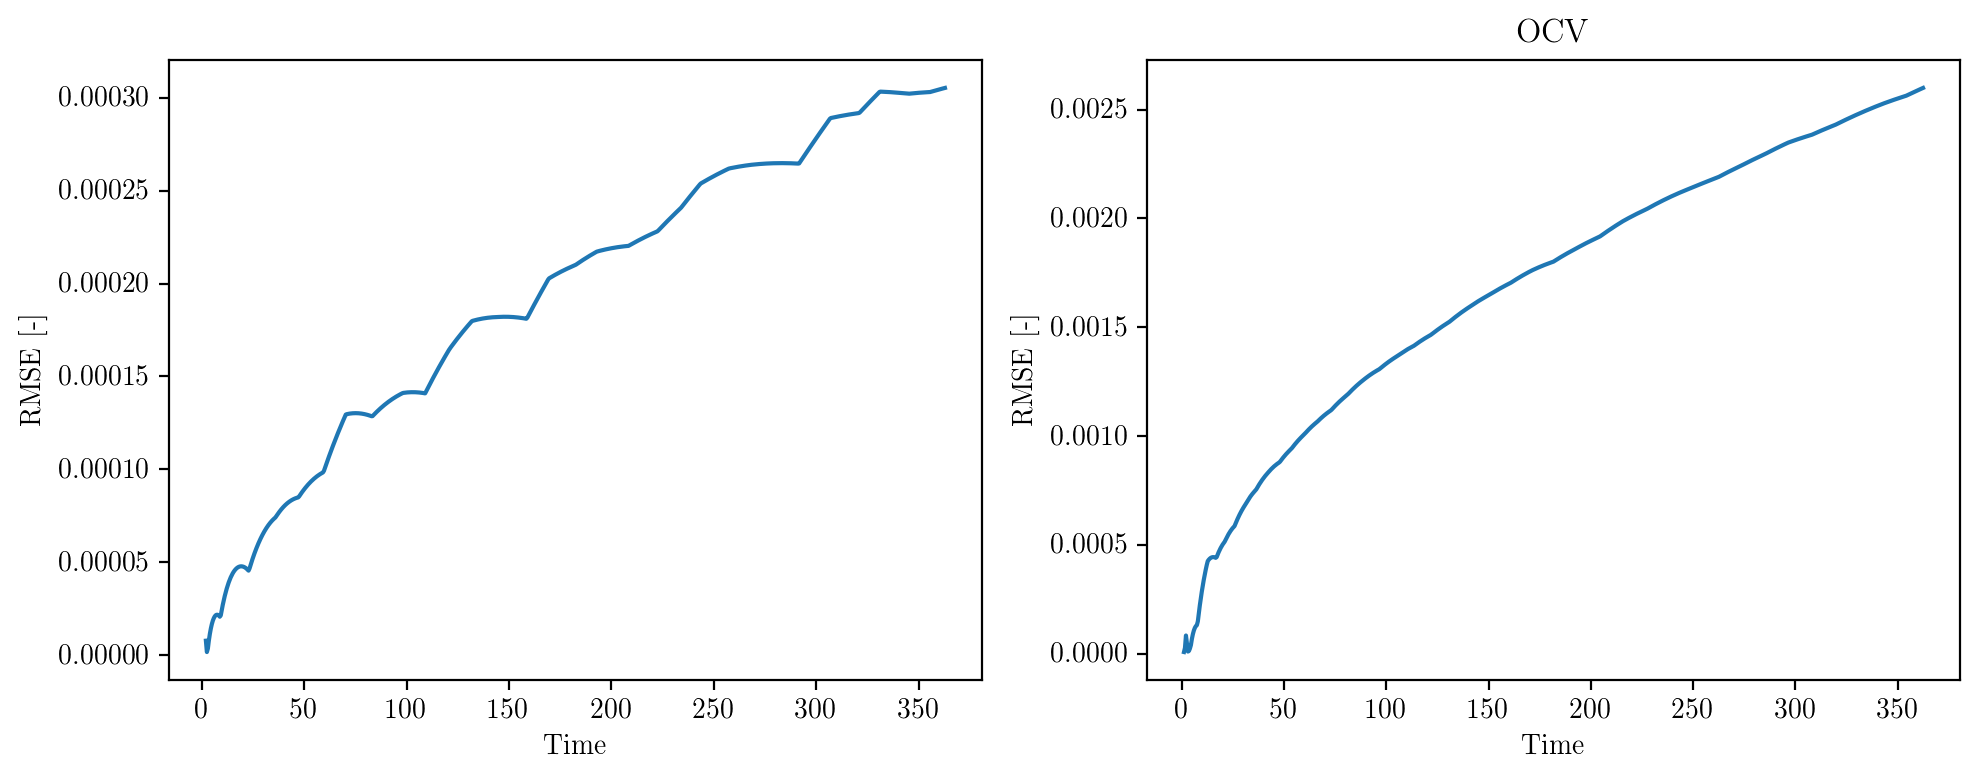

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=200)
time = numpy.linspace(0, max([safari_Q_cycling[:,0][-1], time_cy[-1]/3600/24, 
                              safari_Q_OCV[:,0][-1], time_ocv[-1]/3600/24]), 1000)

real_cy = interp1d(safari_Q_cycling[:,0], safari_Q_cycling[:,1], bounds_error=False)
cidemod_cy = interp1d(time_cy/3600/24, capacity_loss_cy/1.8, bounds_error=False)
real_ocv = interp1d(safari_Q_OCV[:,0], safari_Q_OCV[:,1], bounds_error=False)
cidemod_ocv = interp1d(time_ocv/3600/24, capacity_loss_ocv/1.8, bounds_error=False)

# plot the RMSE over time, cycling parameters
ax1.plot(time, numpy.sqrt((real_cy(time)-cidemod_cy(time))**2/len(time)), "-")
ax1.set_xlabel("Time")
ax1.set_ylabel("RMSE [-]")

# plot the RMSE over time, OCV parameters
ax2.plot(time, numpy.sqrt((real_ocv(time)-cidemod_ocv(time))**2/len(time)), "-")
ax2.set_title("OCV")
ax2.set_xlabel("Time")
ax2.set_ylabel("RMSE [-]")

plt.tight_layout()
plt.show()
# plt.savefig("Storage_RMSE.png")
